## Testing BCM model on MNIST dataset

The first step is the import of the dataset.

In this example we will use the MNIST dataset since it is a very simple dataset and it can be downloaded using the [scikit-learn](https://scikit-learn.org/stable/) APIs.

In particular we will use the MNIST-784 version which includes 60k images of handwritten digits.
Each sample is composed by an image of shape ($28\times28$) interpretable as a vector of $784$ features.

Associated to each image we have the corresponding numeric value as label (as `string`).
The labels can be downloaded setting the `return_X_y` variable to `True`.

To improve the model performances (convergency) we rescaled the full set of features into `[0, 1]`.

In [1]:
#import pylab as plt
from sklearn.datasets import fetch_openml

# Download the MNIST dataset
X, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)

# normalize the sample into [0, 1]
X *= 1. / 255

print('Data size: {}'.format(X.shape))
print('Label size: {}'.format(y.shape))

Data size: (70000, 784)
Label size: (70000,)


First of all we have to import the `BCM` model.

The default parameters of the models can be customized using a different optimization algorithm and/or a different configuration for the weights initialization.
Both these parameters can be set importing the submodules of the package.

In particular in this example we will use an `Adam` optimization algorithm (despite the default Stochastic Gradient Descent) and a weights initialization given by the Glorot Normal distribution (despite the default Normal distribution).

The first can be imported from the `optimizer` submodule, while the second one can be included using the `weights` submodule, as in the example.

A full list of the available activation functions can be found in the `activation` submodule.

We would like to stress that the model performances depend by the right configuration of the full list of the parameters, therefore a fine tuning of them can lead to drastically better/worse results.

For simplicity, in the current example we will use just $10$ epochs for the model training, showing how the model is able to reach good results (in this simple case!) with just few training steps.

In [2]:
from plasticity.model import BCM
from plasticity.model.optimizer import SGD, Adam
from plasticity.model.weights import Normal, GlorotNormal

model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation='relu', 
            optimizer=Adam(learning_rate=4e-2), weights_init=GlorotNormal(),
            interaction_strength=0., verbose=False)

In [3]:
%%time
model.fit(X)

CPU times: user 1min 25s, sys: 1min 51s, total: 3min 16s
Wall time: 12.7 s


BCM(convergency_atol=0.01, batch_size=1000, verbose=False, weights_init=GlorotNormal(), num_epochs=10, epochs_for_convergency=10, outputs=100, random_state=None, activation=Relu(), interaction_strength=0.0, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), precision=1e-30)

Now its time to see what the model has learned into its synapses.

We included an utility function, called `view_weights`, to perform this task.
The function takes the model weights matrix as input a tuple with the dimensions of the input image.
In this way we can plot the resulting synapses' patterns as a sequence of images side-by-side.

**Note:** In this case we are using $100$ neurons, thus the visualization of the weights produces exactly a $10\times10$ image. If you use a different (not perfectly "squarable") number of weights the dimension of the output image will consider only the maximum number of weights displayable into a square matrix (`np.sqrt(weights.shape[0])`)

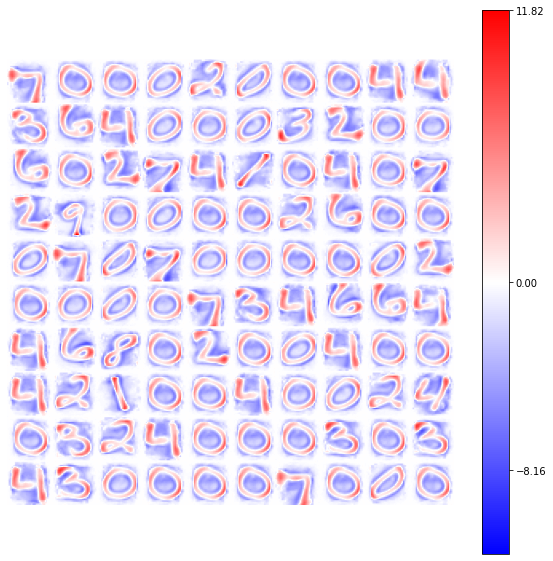

In [4]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(28, 28))

The `GlorotNormal` distribution allows a good convergency of only a small set of available weights.

We can try using a different distribution and see how this result can be affected by the weights initialization strategy.

In the following example we use the default Normal distribution, i.e a Gaussian with $\mu=0$ and $\sigma=1$ (we enlarge the standard deviation of our initial weights), keeping fixed all the other parameters.

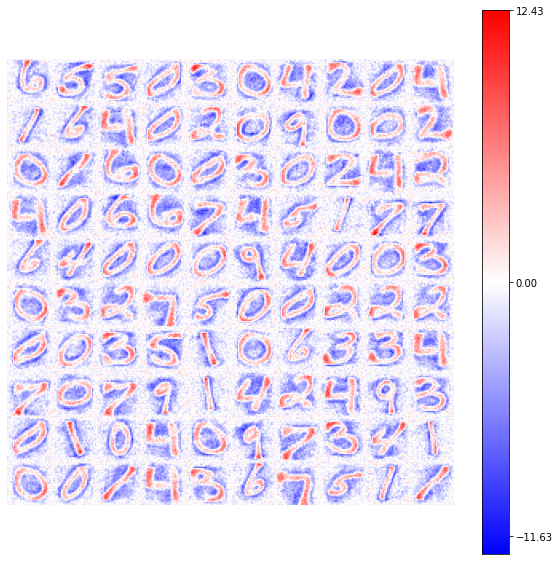

In [5]:
model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation='relu', 
            optimizer=Adam(learning_rate=4e-2), weights_init=Normal(mu=0., std=1.),
            interaction_strength=0., verbose=False)
model.fit(X)
view_weights (model.weights, dims=(28, 28))

You can easily notice how the convergency of the synaptic weights is more unstable refering to the previous result, but in this case all the set of available neurons reach a good configuration of its connections (**memorization**).

We want to put the attention on the shape/color of these connections: in every case the synaptic weights show a positive connection in relation to the shape of the number that they have memorized, while a negative connection is found for the background identification.

It is interesting to notice how the border of the numbers are highlighted by a null-connection shape.
This behaviour is related to the formation of the receptive fields, property already showed in the work of [Blais et al.](https://www.mitpressjournals.org/doi/abs/10.1162/089976698300017142)

We can further increase the standard deviation of the initial weights to obtain a more stable result, enlarging the number of neurons with a "number-configuration".
Doing this, we increase the number of epochs to reach a better result in output.

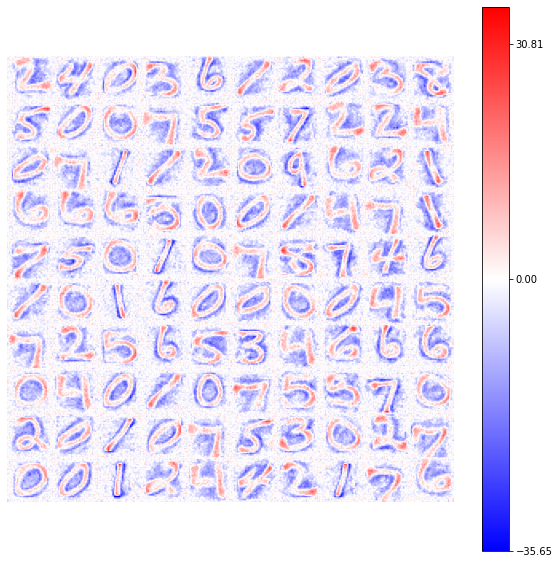

In [6]:
from plasticity.model.weights import Normal

model = BCM(outputs=100, num_epochs=50, batch_size=1000, activation='relu', 
            optimizer=Adam(learning_rate=4e-2), weights_init=Normal(mu=0., std=2.5),
            interaction_strength=0., verbose=False)
model.fit(X)
view_weights (model.weights, dims=(28, 28))

Here you can already notice how the range of possible weights' connections is increased, producing an higher contrast in the number identification (ref. colorbar values).

Using the same number of epochs ($50$) also in the first example (with the `GlorotNormal` distribution), we see how the number of neurons which reach the convergency increase, with a representation of the synaptic connections smoother.

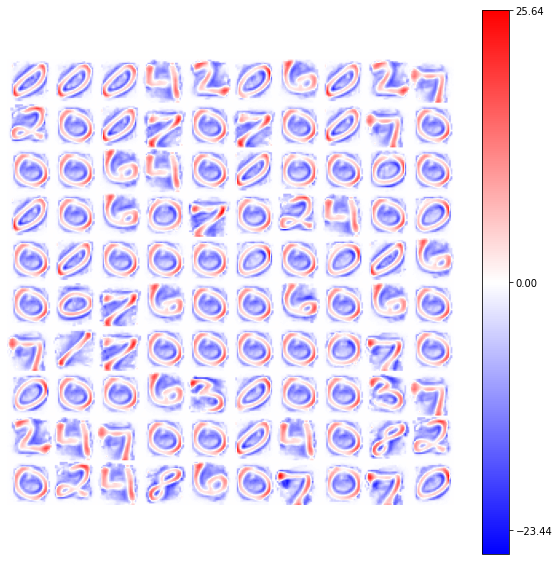

In [7]:
model = BCM(outputs=100, num_epochs=50, batch_size=1000, activation='relu', 
            optimizer=Adam(learning_rate=4e-2), weights_init=GlorotNormal(),
            interaction_strength=0., verbose=False)
model.fit(X)
view_weights (model.weights, dims=(28, 28))

## BCM model with custom activation function

In this example we will try to test the BCM model efficiency using a modified version of the standard `Relu` activation function, showing how the `plasticity` models can be used providing custom activation functions.

First of all, we have to pay attention on the syntax of the `Activation` object.
The object class can be found in the `activations` submodule and its usage can be easily understood.

We have an abstract base class (`Activations`) from which all the specializations inherit.
The base class provides $2$ static methods, called `activate` and `gradient` respectively.
These methods represet the application of the desired activation function and the corresponding gradient assuming that the input is given by an **already-activated** array.

With this idea in mind we can try to implement a shifted version of the `Relu` activation function, such as the breaking point of the two regimes is shifted from $0$ to $-1$.

In [8]:
from plasticity.utils import Activations

class ShiftedRelu (Activations):

    def __init__ (self):
        super(ShiftedRelu, self).__init__('ShiftedRelu')

    @staticmethod
    def activate (x, copy=False):
        if copy: y = x.copy()
        else:    y = x

        y[x < -1.] = 0.
        return y

    @staticmethod
    def gradient (x, copy=False):
        if copy: y = x.copy()
        else:    y = x

        y[x > -1.] = 1.
        y[x <= -1.] = 0.
        return y

Now we can use this new activation function in the BCM model training and see how the results change according to this modification.

**Note:** This custom activation function is defined into the `Python` code, therefore it cannot be used by the `Cython` models which base their computation on the wrap around the activation functions written in `C++`.

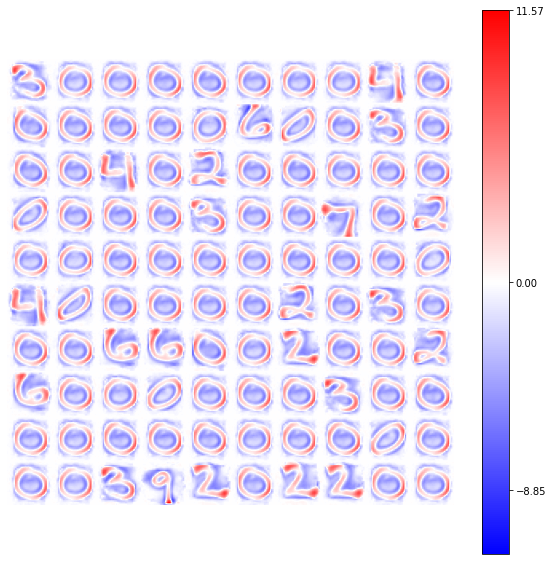

In [9]:
model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation=ShiftedRelu(), 
            optimizer=Adam(learning_rate=4e-2), weights_init=GlorotNormal(),
            interaction_strength=0., verbose=False, random_state=42)
model.fit(X)
view_weights (model.weights, dims=(28, 28))

The following is the result with the classical Relu function (obtained with the same set of parameters and **same random seed**):

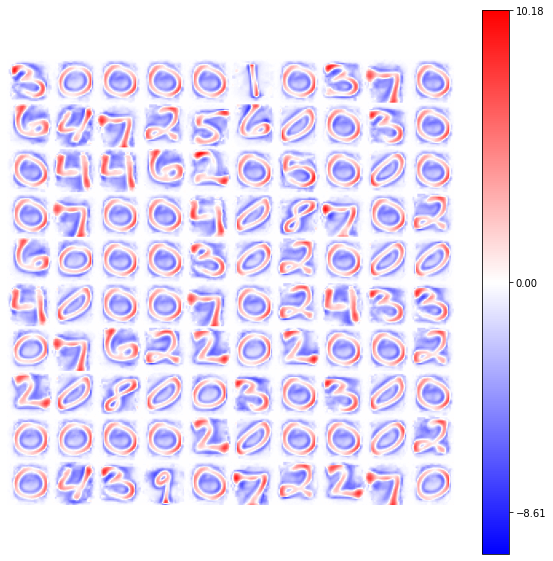

In [10]:
model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation='relu', 
            optimizer=Adam(learning_rate=4e-2), weights_init=GlorotNormal(),
            interaction_strength=0., verbose=False, random_state=42)
model.fit(X)
view_weights (model.weights, dims=(28, 28))

We can notice how the introduction of the `ShiftedRelu` function improves the convergency of the neurons: with the classical `Relu` only a part of the synaptic connections reach the "number-configuration", while the others produce null patterns.

With the `ShiftedRelu` activation function the percentage of the neurons with a "number-configuration" reachs almost totality.
This result is related to the new form of the activation function: with the `ShiftedRelu` we allow the preservation of a small part of negative-values in the output, which facilitate the model convergency and the pattern memorization.

**TODO:** we are working on the introduction of the lateral connections, so we have to fix them before providing an interpretation of the homogenity in the ShiftedRelu version!! If we use a negative lateral connections as in the previous examples the output is better than before but there could be something wrong yet!!

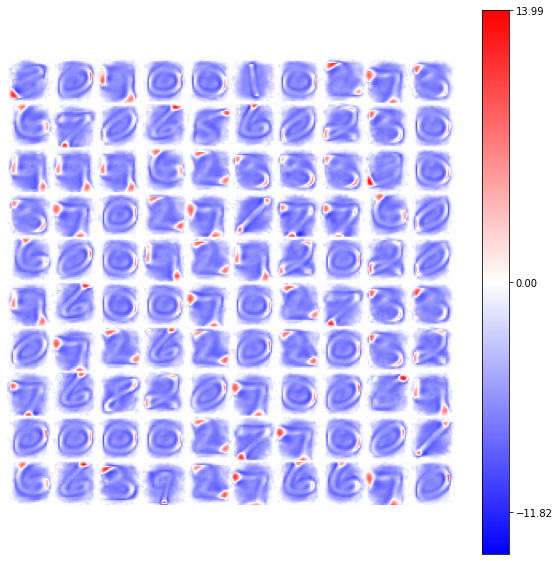

In [11]:
model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation=ShiftedRelu(), 
            optimizer=Adam(learning_rate=4e-2), weights_init=GlorotNormal(),
            interaction_strength=-0.15, verbose=False, random_state=42)
model.fit(X)
view_weights (model.weights, dims=(28, 28))

## BCM inpainting

Up to now we have tested the BCM model efficiency in the problem of pattern memorization.

Now we want to extend the capability of the model, trying to predict the memorized patterns using a part of the input image as "reference".
We call this procedure *inpainting*, i.e we provide to the trained model an half of the original image and we use the synaptic weights we complete the input matrix shape.

In the MNIST dataset we know that the input images are $28\times28$ matrix, thus we can create take one of this image as `reference` (it will be our desired output) and create a copy of it in which we manually set the second half of the image (from the row $14$ until the end) to null values.

Using the prediction of our pre-trained model we can found the activation of each neuron according to the given input.
Each neuron will respond to our input according to what it has learned during the training phase.
In this way an higher response of a neuron will be related to an higher similarity score learned during the training, while a low response will indicate that the pattern memorized by that neuron is very different from what it has learned.

Ranking all the neuron responses, i.e the model predictions, we can select the neuron with the highest output as the best candidate, i.e the neuron with synaptic weights closer to the input pattern.

The combination of the half-input and the synaptic weights learned by our model will help us to reconstruct the original image.

In [12]:
from plasticity.model.weights import Normal

# Train the model on the MNIST dataset
model = BCM(outputs=100, num_epochs=10, batch_size=1000, activation='relu', 
            optimizer=Adam(learning_rate=4e-2), weights_init=GlorotNormal(),
            interaction_strength=-0.1, verbose=False, random_state=42)
model.fit(X)

BCM(activation=Relu(), epochs_for_convergency=10, precision=1e-30, weights_init=GlorotNormal(), convergency_atol=0.01, outputs=100, interaction_strength=-0.1, batch_size=1000, random_state=42, verbose=False, num_epochs=10, optimizer=Adam(decay=0.0, lr_max=inf, lr_min=0.0, lr=0.02))

In [3]:
import numpy as np
import pylab as plt

def inpainting (input_image, dims, model):
    '''
    Apply the inpainting method to the reference image.
    
    We manually set an half of the input image to null
    values and we try to re-create the image using the
    synaptic weigths learned by the model.
    
    Parameters
    ----------
        input_image : array-like
            Input image in ravel format
        
        dims : tuple
            Original dimensions of the input image (2D or 3D)
        
        model : plasticity model
            Pre-trained model to use for the prediction
    
    Returns
    -------
        half_input : array-like
            The processed input image with null values
            in the second half of the image
        
        best_neuron : array-like
            Synaptic weights of the neuron with the
            highest response
        
        inpaint : array-like
            The result of the inpainting process
    '''
    
    reference_data = input_image.reshape(*dims)
    half_input = reference_data.copy()
    
    half_w = dims[0] // 2
    # nullify the lower section of the image
    half_input[half_w:, ...] = 0
    
    # predict the model output
    prediction = model.predict(half_input.reshape(1, -1))
    # select the neuron connections with the highest response
    best_neuron = model.weights[np.argmax(prediction)].reshape(*dims)
    
    inpaint = half_input.copy()
    # use the neuron connections to complete the image
    inpaint[14:, :] = best_neuron[half_w:, ...]
    
    return half_input, best_neuron, inpaint


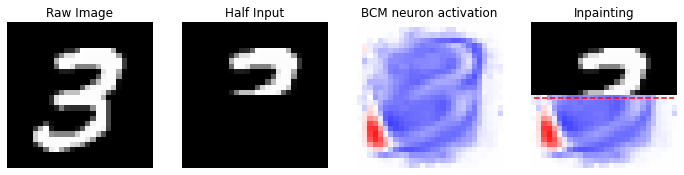

In [14]:
# we select a single image from the MNIST dataset, i.e the image
# in the position idx
idx = 7
reference_data = X[idx].copy()
half_input, best_neuron, inpaint = inpainting(input_image=reference_data, dims=(28, 28), model=model)

nc = np.amax(np.abs(model.weights))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(reference_data.reshape(28, 28), cmap='gray'); ax1.axis('off')
ax2.set_title('Half Input')
ax2.imshow(half_input, cmap='gray'); ax2.axis('off')
ax3.set_title('BCM neuron activation')
ax3.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax3.axis('off')
ax4.set_title('Inpainting')
ax4.imshow(inpaint, cmap='bwr', vmin=-nc, vmax=nc); ax4.axis('off')
ax4.imshow(inpaint[:14, :], cmap='gray')
ax4.hlines(14, 0, 27, color='r', linestyle='dashed')

We can notice how the model is able to correctly predict the remaining part of the image, using the information stored into its synaptic weights.

In this example we are using just $100$ neurons for the training, aiming to store the information about $60$k images.
The number of neurons join with the small number of epochs used allow a correct inpainting of the only pattern memorized by the model.

If we try to "predict" other images, in fact, we can easily notice the limits of this "small" training:

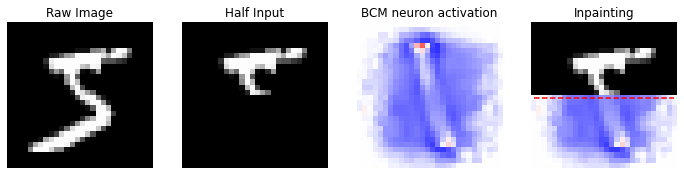

In [15]:
idx = 0
reference_data = X[idx].copy()
half_input, best_neuron, inpaint = inpainting(input_image=reference_data, dims=(28, 28), model=model)

nc = np.amax(np.abs(model.weights))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(reference_data.reshape(28, 28), cmap='gray'); ax1.axis('off')
ax2.set_title('Half Input')
ax2.imshow(half_input, cmap='gray'); ax2.axis('off')
ax3.set_title('BCM neuron activation')
ax3.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax3.axis('off')
ax4.set_title('Inpainting')
ax4.imshow(inpaint, cmap='bwr', vmin=-nc, vmax=nc); ax4.axis('off')
ax4.imshow(inpaint[:14, :], cmap='gray')
ax4.hlines(14, 0, 27, color='r', linestyle='dashed')

In this case the model did not memorize the given pattern and its consequentially predictions are wrong!

It is however interesting to notice how some samples are hard to inpaint also for the human eyes.
In these cases the model tries to produce the better response based on its learning.

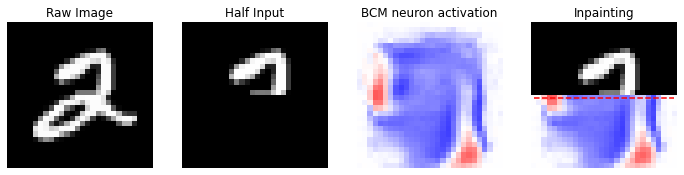

In [16]:
idx = 5
reference_data = X[idx].copy()
half_input, best_neuron, inpaint = inpainting(input_image=reference_data, dims=(28, 28), model=model)

nc = np.amax(np.abs(model.weights))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(reference_data.reshape(28, 28), cmap='gray'); ax1.axis('off')
ax2.set_title('Half Input')
ax2.imshow(half_input, cmap='gray'); ax2.axis('off')
ax3.set_title('BCM neuron activation')
ax3.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax3.axis('off')
ax4.set_title('Inpainting')
ax4.imshow(inpaint, cmap='bwr', vmin=-nc, vmax=nc); ax4.axis('off')
ax4.imshow(inpaint[:14, :], cmap='gray')
ax4.hlines(14, 0, 27, color='r', linestyle='dashed')

This is an evident example, in which the half input image is very "general" and it could correspond to a number $2$, or $3$, or, or $7$, or $8$ or a $9$.
All these possibilities are allowed, but the model "sees" a more agreement with the number $9$.

## BCM classifier

We have learned in the previous example how we can re-think the BCM model in a supervised way.

Now we will try to use the model as a pure classifier, i.e we aim to predict the corresponding digit (label) providing only the input data.

We have already higlighted how the model tries to predict the pattern weighting what it has learned during the training phase.
For a classification task we could consider the top ranking neurons despite the only neuron with the highest response.
In this way we can provide more possible solutions to the same problem and try to interpret what the model sees in the input pattern.

First of all, we have to process the raw labels.

The standard pre-processing in the multi-classifcation tasks is the conversion in some coding of the labels.
A possible way is given by the **one-hot encoding**, in which any label (string) is encoded into a base-vector of null values, in which only the position corresponding to the given lable is set to $1$.

We use the scikit-learn utility to perform this step and then we feed the model with both the data and labels.

**Note:** The plasticity models accept a signature `(X, y)` for the `fit` function, but internally they concatenate the `X` matrix with the `y` labels into a single matrix of data.
The purpose is to provide the label vectors as extra-inputs to the model, i.e adding a set of extra-connections to each neuron.

In [17]:
from sklearn.preprocessing import OneHotEncoder

y_categorical = y.astype('int').reshape(-1, 1)
y_categorical = OneHotEncoder(sparse=False).fit_transform(y_categorical)

model = BCM(outputs=200, num_epochs=10, optimizer=Adam(learning_rate=4e-2), interaction_strength=-0.05,
            weights_init=Normal(),
            activation='Relu', batch_size=1000, verbose=False)
model.fit(X, y=y_categorical)

BCM(outputs=200, activation=Relu(), batch_size=1000, interaction_strength=-0.05, epochs_for_convergency=10, weights_init=Normal(mu=0.0, std=1.0), num_epochs=10, random_state=None, convergency_atol=0.01, precision=1e-30, optimizer=Adam(lr_min=0.0, lr_max=inf, lr=0.02, decay=0.0), verbose=False)

Now we can use what we have learned in the `inpainting` example also in this case: since the new input of the model is given by a vector `[ravel_image, one_hot_encoding_label]`, for the predictions we can manually set the labels to null values.

In [18]:
idx = 10

prediction = model.predict(X[idx].reshape(1, -1), y=np.zeros_like(y_categorical[idx].reshape(1, -1)))
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)
# extract the predicted label for each neuron as argmax of the label-connections
labels = model.weights[:, 28*28:].argmax(axis=1)

best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)

Now despite the highest solution, we rank the output prediction and we extract the top-10 ranking scores, counting how many times the same solution is considered by the model.

In [19]:
from collections import Counter

# extract the top 10 labels as the top-ranking connections
top_10 = sorted(zip(prediction.ravel(), labels), key=lambda x : x[0], reverse=True)[:10]
top_10 = [x[1] for x in top_10]
counter_labels = Counter(top_10)

Top 10 labels: [(3, 5), (9, 3), (5, 1), (8, 1)]


(-0.5, 27.5, 27.5, -0.5)

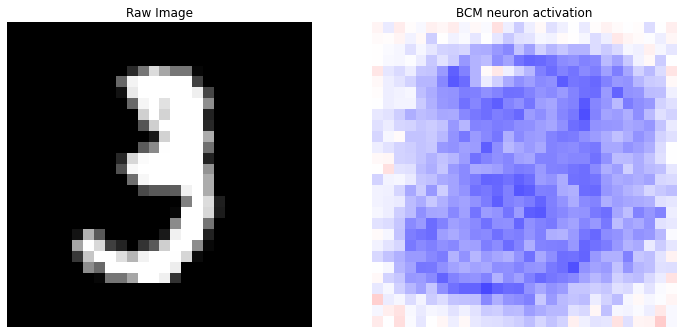

In [20]:
nc = np.amax(np.abs(model.weights))

print('Top 10 labels: {}'.format(counter_labels.most_common()))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(X[idx].reshape(28, 28), cmap='gray'); ax1.axis('off')
ax2.set_title('BCM neuron activation')
im = ax2.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax2.axis('off')

We can see how the $60%$ of the top-10 model's neurons vote for the number $3$ as correct output.
We can also notice how the "best neuron" does not perfectly correspond to the number $3$ that we have provided to the model, but the prediction is however correct.

This example better highlights the capability of the BCM model in learning and memorizing the main characteristics of the given pattern.

For completeness we show in the following the output of the model on different image samples.

Correct label: 5
Top 10 labels: [(3, 4), (5, 2), (2, 2), (6, 1), (8, 1)]
Correct label: 0
Top 10 labels: [(0, 5), (1, 3), (8, 1), (3, 1)]
Correct label: 4
Top 10 labels: [(9, 5), (4, 4), (1, 1)]
Correct label: 1
Top 10 labels: [(8, 2), (9, 2), (5, 2), (0, 1), (1, 1), (2, 1), (4, 1)]


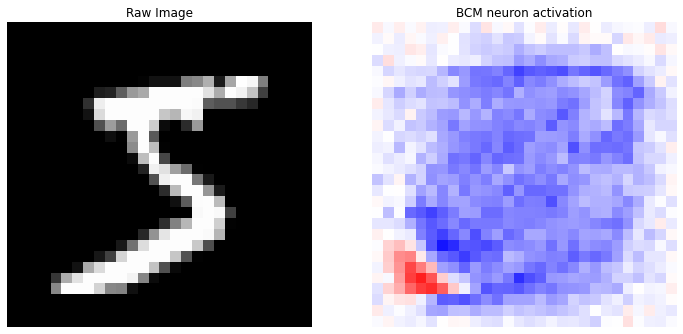

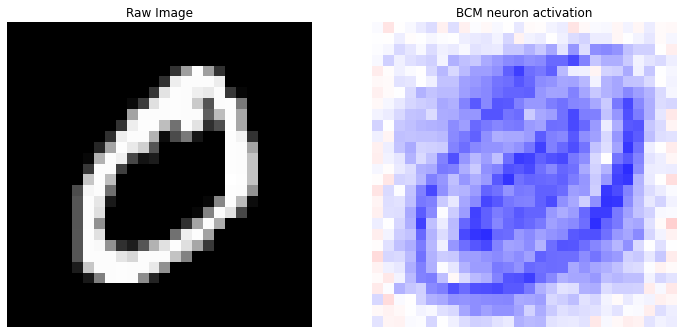

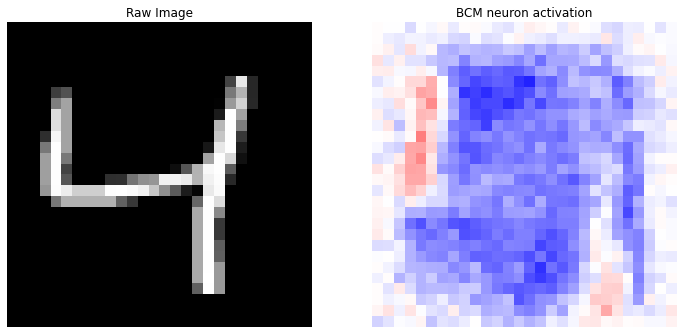

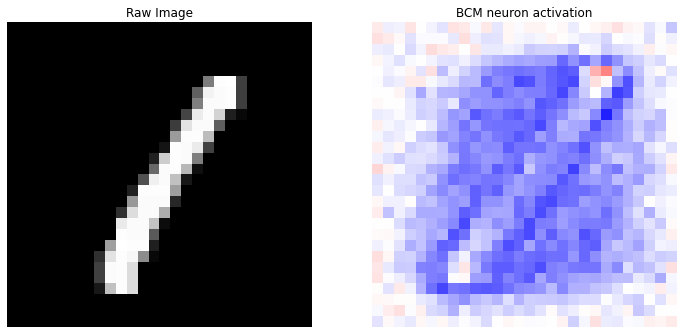

In [21]:
def prediction (X, y, idx):
    prediction = model.predict(X[idx].reshape(1, -1), y=np.zeros_like(y[idx].reshape(1, -1)))
    # select the neuron connections with the highest response
    best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)
    # extract the predicted label for each neuron as argmax of the label-connections
    labels = model.weights[:, 28*28:].argmax(axis=1)

    best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)

    # extract the top 10 labels as the top-ranking connections
    top_10 = sorted(zip(prediction.ravel(), labels), key=lambda x : x[0], reverse=True)[:10]
    top_10 = [x[1] for x in top_10]
    counter_labels = Counter(top_10)

    nc = np.amax(np.abs(model.weights))

    print('Correct label: {:d}'.format(y[idx].argmax()))
    print('Top 10 labels: {}'.format(counter_labels.most_common()))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    ax1.set_title('Raw Image')
    ax1.imshow(X[idx].reshape(28, 28), cmap='gray'); ax1.axis('off')
    ax2.set_title('BCM neuron activation')
    im = ax2.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax2.axis('off')


prediction(X, y_categorical, idx=0)
prediction(X, y_categorical, idx=1)
prediction(X, y_categorical, idx=2)
prediction(X, y_categorical, idx=3)

## BCM classifier performances

Now it is time to think about ML performances and use the model as any other machine learning classifier.

First of all we split the available samples into a *train* and *test* sets, using a $16%$ of the data to train the model and the remaining part to test its performances.

Also in this case we use the scikit-learn API to perform this subdivision.

Since we want to perform a reasonably good classification we have to increase the number of neurons and the number of epochs for the training, trying to balance the computational time required for the simulation and the output performances.

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=1./6, random_state=42)

model = BCM(outputs=1000, num_epochs=10, optimizer=Adam(learning_rate=4e-2), interaction_strength=0.,
            weights_init=Normal(),
            activation='Relu', batch_size=4000, verbose=False)
model.fit(x_train, y_train)

BCM(outputs=1000, activation=Relu(), batch_size=4000, interaction_strength=0.0, epochs_for_convergency=10, weights_init=Normal(mu=0.0, std=1.0), num_epochs=10, random_state=None, convergency_atol=0.01, precision=1e-30, optimizer=Adam(lr_min=0.0, lr_max=inf, lr=0.02, decay=0.0), verbose=False)

Now like any other classifier we can test the accuracy score of its prediction against the ground truth.

**Note:** we have to process the predictions since the labels are given by the "second" part of the weights' connections!

In [27]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X=x_test, y=y_test)
predictions = [model.weights[np.argmax(x)][28*28:].argmax() for x in predictions]

y_true = y_test.argmax(axis=1)
y_pred = np.asarray(predictions)

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, y_pred)))

Accuracy score on test set: 0.774


As before, despite the highest score we can consider the top-10 ranking outputs, performing the classification using the most-common values:

In [28]:
# Prediction using the Top 10 ranking agreement
predictions = model.predict(X=x_test, y=y_test)
labels = model.weights[:, 28*28:].argmax(axis=1)

top_10 = []
for x in predictions:
    # order the predictions
    top = sorted(zip(x, labels), key=lambda x : x[0], reverse=True)[:10]
    top = [x[1] for x in top]
    # select the label as the most common prediction of the ranking
    counter_labels = Counter(top).most_common()
    top_10.append(counter_labels[0][0])

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, top_10)))

Accuracy score on test set: 0.857


As expected the performances of the model grow since we prevent possible misleading in the pattern identification!

We would like to stress that in the work of [Krotov et al.](https://www.pnas.org/content/116/16/7723) the authors suggest to use a combination of `unsupervised bio-learning` model and `supervised back-propagation` model for the classification, while with this simple example we have proofed how we can join together these two steps into a single model!

## Testing BCM model on CIFAR-10 dataset

Now it is time to move to a more complex dataset.

Following the paper of [Krotov et al.](https://www.pnas.org/content/116/16/7723) a more complex dataset is given by the CIFAR-10.

In CIFAR-10 we have $50k$ ($32\times32$) RGB images, divided into $10$ classes.

The variability of the samples is higher in comparison with the MNIST dataset and the introduction of $3$ channels into the input drastically increase the number of parameters to learn.

We however try to memorize this dataset using the BCM model.

In this example we will use the `tensorflow` library for the download of the dataset.

The dataset is already divided into `train` and `test`, thus we will use only the `train` part for our application.

In [13]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

shape = x_train.shape[1:]
X = x_train.reshape(x_train.shape[0], -1)
X = X.astype(float)
X *= 1. / 255

x_train.shape

(50000, 32, 32, 3)

Now we can try to build our BCM model using different training parameters.

In particular, we increase the `batch_size`, since we want a faster convergency of the model.
We also use a `Normal` distribution for the weights initialization, since the purpose is to obtain a convergency of at least one neuron in this phase.

To reach a reasonable result also the number of epochs must increase: in this case we use $100$ epochs of training.

In [29]:
model = BCM(outputs=100, num_epochs=100, optimizer=Adam(learning_rate=4e-2), 
            weights_init=GlorotNormal(),
            interaction_strength=0.,
            activation='Relu', batch_size=3000, verbose=False)
model.fit(X)

BCM(convergency_atol=0.01, batch_size=3000, verbose=False, weights_init=GlorotNormal(), num_epochs=100, epochs_for_convergency=100, outputs=100, random_state=None, activation=Relu(), interaction_strength=0.0, optimizer=Adam(lr_max=inf, decay=0.0, lr=0.02, lr_min=0.0), precision=1e-30)

Now we can try to visualize what the model has learned into its synaptic weights and as in the previous example we can use the `view_weights` utility function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


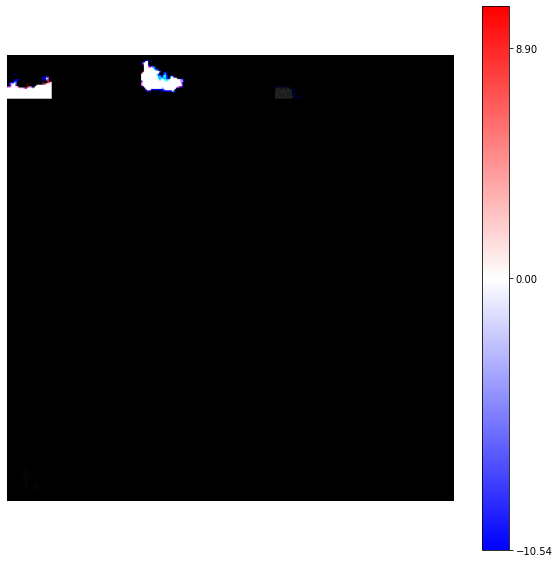

In [30]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(32, 32, 3))

The result seems to be very strange!

However, seeing the warning raised by the function we have to re-think about the visualization.

In this example we are using RGB images, i.e matrix of `uint8`.
Moreover the variability of the pixel values can be very high and a normalization according to the full set of weights can affect some matrices.

We can re-write the `view_weights` using a standardization of the synaptic weights according to each neuron, rescaling the value into the range `[0, 255]` as `uint8`.

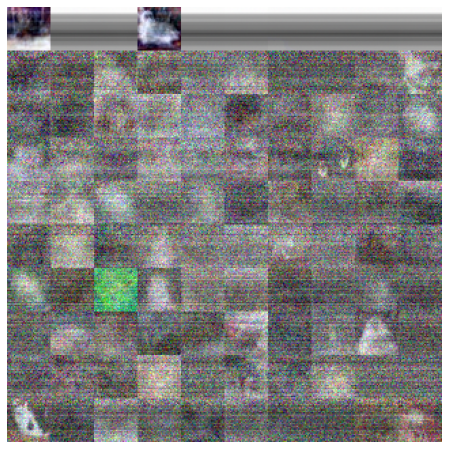

In [31]:
import numpy as np
import pylab as plt

float_2_img = lambda im : ((im - im.min()) * (1./(im.max() - im.min()) * 255.)).astype(np.uint8)

num_images = int(np.sqrt(model.weights.shape[0]))
selected_weights = model.weights[:num_images**2]
image = np.hstack(np.hstack(selected_weights.reshape(num_images, num_images, *shape)))

image = np.asarray([float_2_img(im) for im in image])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.axis('off')
im = ax.imshow(image)

**WORK IN PROGRESS**

## Testing Hopfield model on MNIST dataset

In [14]:
from plasticity.model import Hopfield

model = Hopfield(outputs=100, num_epochs=10, verbose=False)
model.fit(X)

Hopfield(convergency_atol=0.01, delta=0.4, mu=0.0, batch_size=100, sigma=1.0, outputs=100, epochs_for_convergency=10, random_state=42, num_epochs=10, verbose=False, precision=1e-30, k=2, p=2.0, optimizer=SGD(lr=0.02, lr_min=0.0, decay=0.0, lr_max=inf))

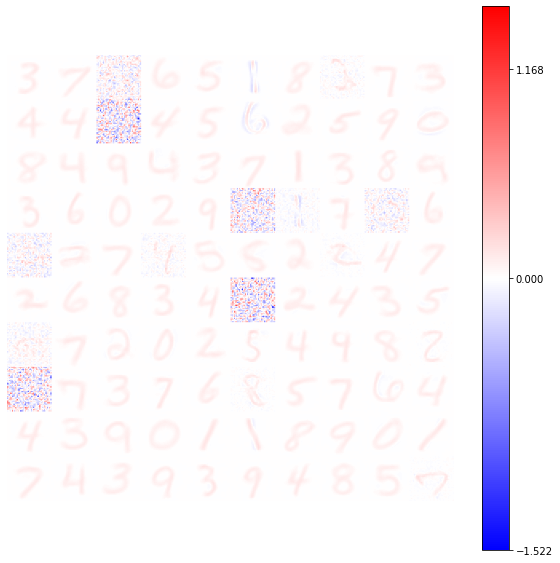

In [15]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(28, 28))

## Hopfield inpainting

In [16]:
import numpy as np
import pylab as plt

idx = 1
reference_data = X[idx].reshape(28, 28)
half_input = reference_data.copy()
# nullify the lower section of the image
half_input[14:, :] = 0.

# prediction with linear activation function
prediction = np.einsum('ij, kj -> ik', model.weights, half_input.reshape(1, -1), optimize=True).T
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)].reshape(28, 28)

inpaint = half_input.copy()
# use the neuron connections to complete the image
inpaint[14:, :] = best_neuron[14:, :]

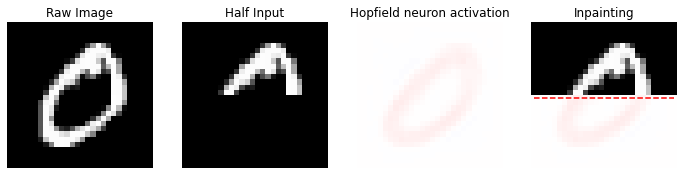

In [17]:
nc = np.amax(np.abs(model.weights))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(reference_data, cmap='gray'); ax1.axis('off')
ax2.set_title('Half Input')
ax2.imshow(half_input, cmap='gray'); ax2.axis('off')
ax3.set_title('Hopfield neuron activation')
ax3.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax3.axis('off')
ax4.set_title('Inpainting')
ax4.imshow(inpaint, cmap='bwr', vmin=-nc, vmax=nc); ax4.axis('off')
ax4.imshow(inpaint[:14, :], cmap='gray')
ax4.hlines(14, 0, 27, color='r', linestyle='dashed')

## Hopfield classifier

In [18]:
from sklearn.preprocessing import OneHotEncoder

y_categorical = y.astype('int').reshape(-1, 1)
y_categorical = OneHotEncoder(sparse=False).fit_transform(y_categorical)

model = Hopfield(outputs=200, num_epochs=10, optimizer=Adam(learning_rate=4e-2),
                 batch_size=1000, verbose=False)
model.fit(X, y=y_categorical)

Hopfield(convergency_atol=0.01, delta=0.4, mu=0.0, batch_size=1000, sigma=1.0, outputs=200, epochs_for_convergency=10, random_state=42, num_epochs=10, verbose=False, precision=1e-30, k=2, p=2.0, optimizer=Adam(lr=0.02, lr_min=0.0, decay=0.0, lr_max=inf))

In [19]:
idx = 50
reference_data = X[idx].reshape(28, 28)
# set the corresponding labels to null
reference_data[28*28 :] = 0

prediction = model.predict(X[idx].reshape(1, -1), y=y_categorical[idx].reshape(1, -1))
# select the neuron connections with the highest response
best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)
# extract the predicted label for each neuron as argmax of the label-connections
labels = model.weights[:, 28*28:].argmax(axis=1)

best_neuron = model.weights[np.argmax(prediction)][:28*28].reshape(28, 28)

In [20]:
from collections import Counter

# extract the top 10 labels as the top-ranking connections
top_10 = sorted(zip(prediction.ravel(), labels), key=lambda x : x[0], reverse=True)[:10]
top_10 = [x[1] for x in top_10]
counter_labels = Counter(top_10)

Top 10 labels: [(3, 9), (5, 1)]


(-0.5, 27.5, 27.5, -0.5)

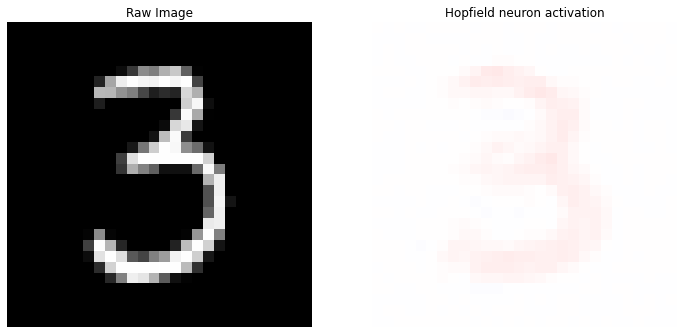

In [21]:
nc = np.amax(np.abs(model.weights))

print('Top 10 labels: {}'.format(counter_labels.most_common()))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax1.set_title('Raw Image')
ax1.imshow(X[idx].reshape(28, 28), cmap='gray'); ax1.axis('off')
ax2.set_title('Hopfield neuron activation')
im = ax2.imshow(best_neuron, cmap='bwr', vmin=-nc, vmax=nc); ax2.axis('off')

## Hopfield classifier performances

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=1/6, random_state=42)

model = Hopfield(outputs=1000, num_epochs=20, optimizer=Adam(learning_rate=4e-2),
                 batch_size=4000, verbose=False)
model.fit(x_train, y_train)

Hopfield(convergency_atol=0.01, delta=0.4, mu=0.0, batch_size=4000, sigma=1.0, outputs=1000, epochs_for_convergency=20, random_state=42, num_epochs=20, verbose=False, precision=1e-30, k=2, p=2.0, optimizer=Adam(lr=0.02, lr_min=0.0, decay=0.0, lr_max=inf))

In [23]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X=x_test, y=y_test)
predictions = [model.weights[np.argmax(x)][28*28:].argmax() for x in predictions]

y_true = y_test.argmax(axis=1)
y_pred = np.asarray(predictions)

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, y_pred)))

Accuracy score on test set: 0.848


In [24]:
# Prediction using the Top 10 ranking agreement
predictions = model.predict(X=x_test, y=y_test)
labels = model.weights[:, 28*28:].argmax(axis=1)

top_10 = []
for x in predictions:
    # order the predictions
    top = sorted(zip(x, labels), key=lambda x : x[0], reverse=True)[:10]
    top = [x[1] for x in top]
    # select the label as the most common prediction of the ranking
    counter_labels = Counter(top).most_common()
    top_10.append(counter_labels[0][0])

print('Accuracy score on test set: {:.3f}'.format(accuracy_score(y_true, top_10)))

Accuracy score on test set: 0.901
